## distance to target (After hitting, make it retain its position)

In [1]:
import os
from pathlib import Path
import sys
path = Path(os.getcwd())

# need to include path to the root of this reprository
# abspath = '/home2/sangjoon/project/eegdecode/bci_plot/bci_plot'
abspath = str(path.absolute().parent.parent / 'bci_plot')
sys.path.append(abspath)

In [2]:
figure_creation_param = {
    'path':str(path.absolute().parent.parent / 'figs' / 'Distance To Target'),
}
(Path(figure_creation_param['path'])).mkdir(parents=True, exist_ok=True)

In [3]:
from tools.data_util import load_data
from tools.iterate import get_copilot_session_names, get_copilot_session_by_ABA, get_trial_beginning_end, get_dial_in_time
from tools.plot import plotMeanStdBox
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import datetime
import yaml
import tqdm

In [4]:
## all data in interest from exp tracker
copilotSessions = get_copilot_session_names()
copilotABASessions = get_copilot_session_by_ABA()

## distance to target for 4 subject

In [5]:
# get time to touch
copilotABASessions = get_copilot_session_by_ABA()


DTTAllA1 = []
DTTAllA2 = []
DTTAllB = []
maxLength = 500
tickLength = 0.05
trialTimeX = np.arange(500) * tickLength


Collection = {}
subjects = ['H1','H2','H4','S2']
ABAlabels = ['A1','B1','A2']
for s in subjects:
    Collection[s] = {}
    for label in ABAlabels:
        Collection[s][label] = {'DTT':np.zeros(maxLength),'n':0}


for i, ABAsession in tqdm.tqdm(enumerate(copilotABASessions)):
    for sessionName, label in zip(ABAsession, ABAlabels):

        dataPath = Path('/data/raspy')
        taskData = load_data(dataPath / sessionName / 'task.bin')
        beginEnd = get_trial_beginning_end(taskData)

        # first plot the distance to target (DTT)
        DTT = np.linalg.norm(taskData['target_pos'] - taskData['decoded_pos'], axis=1)
        
        # add it to correct bin
        for subject in subjects:
            if subject in sessionName:
                # at most 500 ticks long trial. 0.050ms at most 25 second long
                for begin, end in beginEnd[4:]:
                    Collection[subject][label]['DTT'][0:end-begin] += DTT[begin:end]
                    Collection[subject][label]['DTT'][end-begin:] += DTT[end]
                    Collection[subject][label]['n'] += 1
                    

# find average
for s in subjects:
    for label in ABAlabels:
        Collection[s][label]['DTT'] /= Collection[s][label]['n']

0it [00:00, ?it/s]

13it [00:01,  9.73it/s]


## DDT.m replicated

In [6]:
# get time to touch
maxLength = 500
tickLength = 0.05
trialTimeX = np.arange(500) * tickLength


copilotSessions = get_copilot_session_names(label=True)
DTTCollection = {}
subjects = ['H1','H2','H4','S2', 'Healthy', 'SCI']
ABAlabels = ['A','B']
metrics = ['DTT', 'TFA', 'TT']
for s in subjects:
    DTTCollection[s] = {}
    for label in ABAlabels:
        DTTCollection[s][label] = {
            'DTT':np.zeros(maxLength),
            'TFA': [],
            'TT': [],
            'n':0,
            }
        
for sessionName, label in tqdm.tqdm(copilotSessions):
    # getSessionName, subject name, label
    subjectName = sessionName.split('_')[1]

    dataPath = Path('/data/raspy')
    taskData = load_data(dataPath / sessionName / 'task.bin')
    timeToFirstAcquire, dialInTime, totalTrialTime = get_dial_in_time(taskData)

    # change to numpy format
    timeToFirstAcquire = [item for item in timeToFirstAcquire if item is not None]

    # add it to correct bin
    DTTCollection[subjectName][label]['TFA'] += timeToFirstAcquire
    DTTCollection[subjectName][label]['TT'] += totalTrialTime
    
    # get TFA
    dataPath = Path('/data/raspy')
    taskData = load_data(dataPath / sessionName / 'task.bin')
    beginEnd = get_trial_beginning_end(taskData)

    # first plot the distance to target (DTT)
    DTT = np.linalg.norm(taskData['target_pos'] - taskData['decoded_pos'], axis=1)
    
    # at most 500 ticks long trial. 0.050ms at most 25 second long
    for begin, end in beginEnd[4:]:
        DTTCollection[subjectName][label]['DTT'][0:end-begin] += DTT[begin:end]
        DTTCollection[subjectName][label]['DTT'][end-begin:] += DTT[end]
        DTTCollection[subjectName][label]['n'] += 1

# Healthy & SCI
for label in ABAlabels:
    for s in subjects:
        if 'H' in s and len(s) == 2:
            DTTCollection['Healthy'][label]['TFA'] += DTTCollection[s][label]['TFA']
            DTTCollection['Healthy'][label]['TT'] += DTTCollection[s][label]['TT']
            DTTCollection['Healthy'][label]['DTT'] += DTTCollection[s][label]['DTT']
            DTTCollection['Healthy'][label]['n'] += DTTCollection[s][label]['n']

        if 'S' in s and len(s) == 2:
            DTTCollection['SCI'][label]['TFA'] += DTTCollection[s][label]['TFA']
            DTTCollection['SCI'][label]['TT'] += DTTCollection[s][label]['TT']
            DTTCollection['SCI'][label]['DTT'] += DTTCollection[s][label]['DTT']
            DTTCollection['SCI'][label]['n'] += DTTCollection[s][label]['n']
        

# find average
for s in subjects:
    for label in ABAlabels:
        DTTCollection[s][label]['avgDTT'] = DTTCollection[s][label]['DTT'] / DTTCollection[s][label]['n']
        TFA = DTTCollection[s][label]['TFA']
        TT = DTTCollection[s][label]['TT']
        DTTCollection[s][label]['avgTFA'] = sum(TFA) / len(TFA)
        DTTCollection[s][label]['avgTT'] = sum(TT) / len(TT)

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:02<00:00, 14.88it/s]


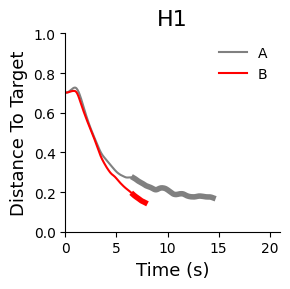

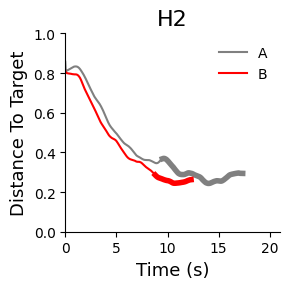

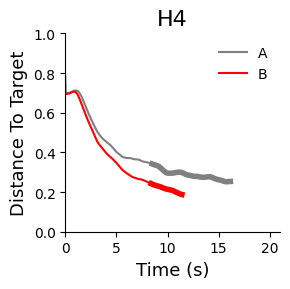

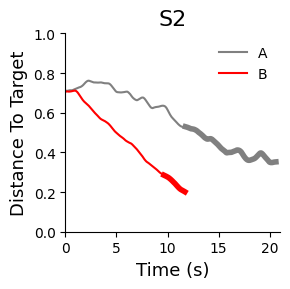

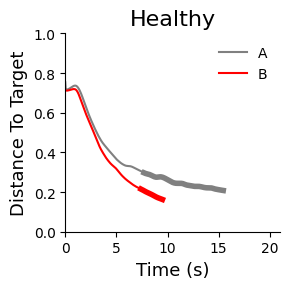

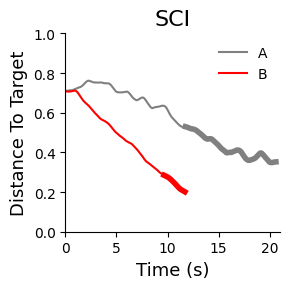

In [7]:
# find average
for s in subjects:
    DTTCollection[s][label]['avgDTT'] # Y
    trialTimeX # X

    fig, ax = plt.subplots(figsize= (3, 3))
    x1, x2, x3 = 0.1, 0.25, 0.4

    # truncate zeros
    for label in ABAlabels:
        DTT = DTTCollection[s][label]['avgDTT']
        DTT = DTT[DTT!=0]
        DTTCollection[s][label]['time'] = trialTimeX[:len(DTT)]

    # bolded for avgTFA
    TFAIndexA = int(DTTCollection[s]['A']['avgTFA'] // tickLength)
    TTIndexA  = int(DTTCollection[s]['A']['avgTT'] // tickLength)
    TFAIndexB = int(DTTCollection[s]['B']['avgTFA'] // tickLength)
    TTIndexB  = int(DTTCollection[s]['B']['avgTT'] // tickLength)
    
    # thin
    ax.plot(DTTCollection[s][ABAlabels[0]]['time'][:TTIndexA], DTTCollection[s][ABAlabels[0]]['avgDTT'][:TTIndexA], color = 'grey', label = 'A')
    ax.plot(DTTCollection[s][ABAlabels[1]]['time'][:TTIndexB], DTTCollection[s][ABAlabels[1]]['avgDTT'][:TTIndexB], color = 'red', label = 'B')
    
    # thick
    ax.plot(DTTCollection[s][ABAlabels[0]]['time'][TFAIndexA:TTIndexA], DTTCollection[s][ABAlabels[0]]['avgDTT'][TFAIndexA:TTIndexA], color = 'grey', linewidth=4)
    ax.plot(DTTCollection[s][ABAlabels[1]]['time'][TFAIndexB:TTIndexB], DTTCollection[s][ABAlabels[1]]['avgDTT'][TFAIndexB:TTIndexB], color = 'red', linewidth=4)
    
    ax.set_xlim([0,21])
    ax.set_xlabel('Time (s)', fontsize=13)
    ax.set_ylabel('Distance To Target', fontsize = 13)
    ax.set_ylim(0,1.0)

    # manual ticks
    y_ticks = np.array([0,0.2,0.4,0.6,0.8,1.0])
    ax.set_yticks(y_ticks)

    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(s, fontsize = 16)
    ax.legend(loc='upper right', fontsize=10, frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # plt.title(f'Path Efficiency Comparison')
    # plt.show()
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()

    #plt.savefig(f'{figure_creation_param["path"]}/Distance To Target DTT.m (after Held, pos retained) AB {s}.pdf')

# AU to CM

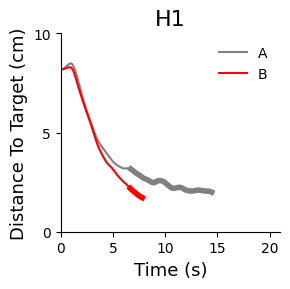

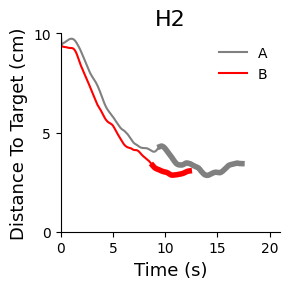

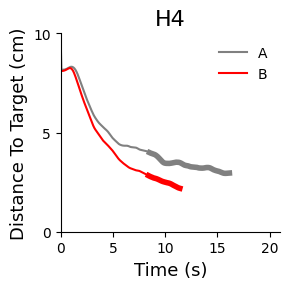

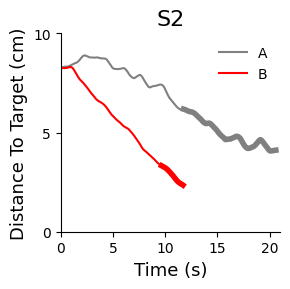

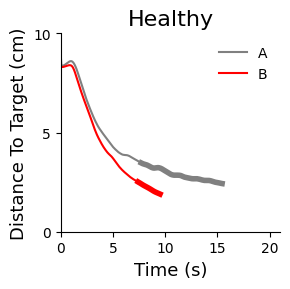

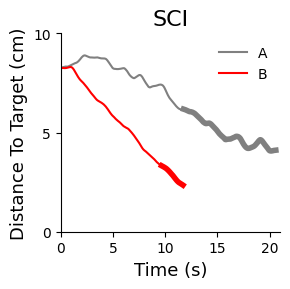

In [8]:
# find average
for s in subjects:
    DTTCollection[s][label]['avgDTT'] # Y
    trialTimeX # X

    fig, ax = plt.subplots(figsize= (3, 3))
    x1, x2, x3 = 0.1, 0.25, 0.4

    # truncate zeros
    for label in ABAlabels:
        DTT = DTTCollection[s][label]['avgDTT']
        DTT = DTT[DTT!=0]
        DTTCollection[s][label]['time'] = trialTimeX[:len(DTT)]

    # bolded for avgTFA
    TFAIndexA = int(DTTCollection[s]['A']['avgTFA'] // tickLength)
    TTIndexA  = int(DTTCollection[s]['A']['avgTT'] // tickLength)
    TFAIndexB = int(DTTCollection[s]['B']['avgTFA'] // tickLength)
    TTIndexB  = int(DTTCollection[s]['B']['avgTT'] // tickLength)
    
    # thin
    # 1 a.u. = 11.675cm
    conversionUnit = 11.675
    AX = DTTCollection[s][ABAlabels[0]]['time'][:TTIndexA]
    AY = DTTCollection[s][ABAlabels[0]]['avgDTT'][:TTIndexA] * conversionUnit
    BX = DTTCollection[s][ABAlabels[1]]['time'][:TTIndexB]
    BY = DTTCollection[s][ABAlabels[1]]['avgDTT'][:TTIndexB] * conversionUnit
    ax.plot(AX, AY, color = 'grey', label = 'A')
    ax.plot(BX, BY, color = 'red', label = 'B')
    
    # thick
    AX = DTTCollection[s][ABAlabels[0]]['time'][TFAIndexA:TTIndexA]
    AY = DTTCollection[s][ABAlabels[0]]['avgDTT'][TFAIndexA:TTIndexA] * conversionUnit
    BX = DTTCollection[s][ABAlabels[1]]['time'][TFAIndexB:TTIndexB]
    BY = DTTCollection[s][ABAlabels[1]]['avgDTT'][TFAIndexB:TTIndexB] * conversionUnit
    ax.plot(AX, AY, color = 'grey', linewidth=4)
    ax.plot(BX, BY, color = 'red', linewidth=4)
    
    ax.set_xlim([0,21])
    ax.set_xlabel('Time (s)', fontsize=13)
    ax.set_ylabel('Distance To Target (cm)', fontsize = 13)
    ax.set_ylim(0,1.0)

    # manual ticks
    y_ticks = np.array([0,5,10])
    ax.set_yticks(y_ticks)

    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(s, fontsize = 16)
    ax.legend(loc='upper right', fontsize=10, frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # plt.title(f'Path Efficiency Comparison')
    # plt.show()
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()

    plt.savefig(f'{figure_creation_param["path"]}/Distance To Target DTT.m (after Held, pos retained) AB {s} (cm).pdf')